1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [1]:
#Packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import scipy as sc
from scipy import stats
import pandas as pd
import seaborn as sns
from scipy import linalg as la

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$

In [2]:
#N entries
N = 3000

x1 = np.random.normal(0,1,N)
x2 = x1 + np.random.normal(0,3,N)
x3 = 2*x1 + x2

#Dataset with 3 features
dataset = np.array([x1,x2,x3])
print("Dataset:\n", dataset)

Dataset:
 [[-0.04971167 -0.71878738 -1.53201939 ... -0.70087405  0.76523135
  -0.07084049]
 [-2.92168084 -0.24309919 -3.55298535 ... -4.86568886  2.8692322
  -3.39680178]
 [-3.02110419 -1.68067394 -6.61702413 ... -6.26743696  4.39969489
  -3.53848275]]


* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset

In [3]:
#covariance matrix of the dataset
cm = np.cov(dataset)
l, V = la.eig(cm) #l is the spectrum and V the normalized eigevectors
l = np.real_if_close(l) #If input is complex with all imaginary parts close to zero, return real parts. EigValue must be real

#sorting to than check that the two procedures yield to same result
idx = np.argsort(-l)
l = l[idx]
V = V[:,idx]

print("The covariance matrix of the dataset is:\n\n",cm,'\n')

print("Eigenvalue n. 1:", l[0], "\nEigenvector n. 1: ", V[:,0])
print("\n\nEigenvalue n. 2: ", l[1], "\nEigenvector n. 2:", V[:,1])
print("\n\nEigenvalue n. 3: ", l[2], "\nEigenvector n. 3:", V[:,2])

The covariance matrix of the dataset is:

 [[ 0.97593041  1.01641334  2.96827417]
 [ 1.01641334  9.85561465 11.88844133]
 [ 2.96827417 11.88844133 17.82498966]] 

Eigenvalue n. 1: 26.729374480602946 
Eigenvector n. 1:  [-0.11596612 -0.57672991 -0.80866215]


Eigenvalue n. 2:  1.927160244208636 
Eigenvector n. 2: [ 0.56558394 -0.70761285  0.42355503]


Eigenvalue n. 3:  -3.0362195739542784e-16 
Eigenvector n. 3: [-0.81649658 -0.40824829  0.40824829]


* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result

In [4]:
print("SVD method: ")
U, spectrum, Vt = np.linalg.svd(cm)
#U, spectrum, Vt = la.svd(cm)

print("Eigenvalue n. 1:", spectrum[0], "\nEigenvector SVD n. 1: ", Vt[:,0])
print("\n\nEigenvalue n. 2: ", spectrum[1], "\nEigenvector SVD n. 2:", Vt[:,1])
print("\n\nEigenvalue n. 3: ", spectrum[2], "\nEigenvector SVD n. 3:", Vt[:,2])

print("\n\nCheck using eigenvalue equation: ")

sx1 = np.dot(cm, V[:,0])
dx1 = l[0] * V[:,0]
sx2 = np.dot(cm, V[:,1])
dx2 = l[1] * V[:,1]
sx3 = np.dot(cm, V[:,2])
dx3 = l[2] * V[:,2]

print("Eigenvalue n. 1:\n", sx1, dx1)
print("Eigenvalue n. 2:\n", sx2, dx2)
print("Eigenvalue n. 3:\n", sx3, dx3)

SVD method: 
Eigenvalue n. 1: 26.729374480602928 
Eigenvector SVD n. 1:  [-0.11596612  0.56558394  0.81649658]


Eigenvalue n. 2:  1.9271602442086362 
Eigenvector SVD n. 2: [-0.57672991 -0.70761285  0.40824829]


Eigenvalue n. 3:  1.4171085384973802e-15 
Eigenvector SVD n. 3: [-0.80866215  0.42355503 -0.40824829]


Check using eigenvalue equation: 
Eigenvalue n. 1:
 [ -3.0997018  -15.41562977 -21.61503337] [ -3.0997018  -15.41562977 -21.61503337]
Eigenvalue n. 2:
 [ 1.08997088 -1.36368335  0.81625842] [ 1.08997088 -1.36368335  0.81625842]
Eigenvalue n. 3:
 [-5.55111512e-16  1.77635684e-15 -1.77635684e-15] [ 2.47906290e-16  1.23953145e-16 -1.23953145e-16]


* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.

In [5]:
# Variability
Lambda=np.diag(l)
v1 = Lambda[0,0]/Lambda.trace()
v2 = Lambda[1,1]/Lambda.trace()
v3 = Lambda[2,2]/Lambda.trace()

print("Eigenvalue n. 1 percent of the variability : ", v1*100)
print("Eigenvalue n. 2 percent of the variability : ", v2*100)
print("Eigenvalue n. 3 percent of the variability : ", v3*100)

Lambda[2,2] = 0
reduce = np.delete(Lambda, 2,0)
reduce = np.delete(reduce, 2,1)
print("Reduced matrix: \n", reduce)

Eigenvalue n. 1 percent of the variability :  93.27497109223032
Eigenvalue n. 2 percent of the variability :  6.7250289077696825
Eigenvalue n. 3 percent of the variability :  -1.0595208398751158e-15
Reduced matrix: 
 [[26.72937448  0.        ]
 [ 0.          1.92716024]]


Since x3 is the linear combination of x1 and x2, all the variability belongs to x1 and x2. The variability is not zero for x3. Since, as you can see in the check made above, the third eigenvalue probably does not coincide because it is too small and the two methods fail. 

* Redefine the data in the basis yielded by the PCA procedure

Text(0, 0.5, 'x2')

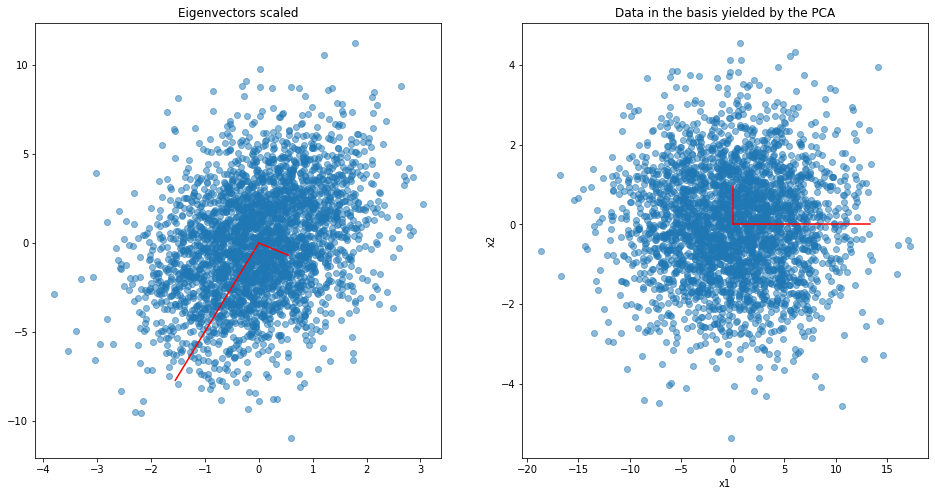

In [6]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax0.scatter(dataset[0,:], dataset[1,:],alpha = 0.5)
scale_factor=0.5

for li, vi in zip(l, V.T): 
    ax0.plot([0, scale_factor*li*vi[0]], [0, scale_factor*li*vi[1]], color = "r")

ax0.set_title("Eigenvectors scaled")

# rotate all the data points accordingly to the new base

rotdat = np.dot(V.T, dataset)
ax1.scatter(rotdat[0,:], rotdat[1,:], alpha=0.5)

for li, vi in zip(l, np.diag([1]*2)):
    plt.plot([0, scale_factor*li*vi[0]], [0, scale_factor*li*vi[1]], color = "r")

ax1.set_title("Data in the basis yielded by the PCA")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")

* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.

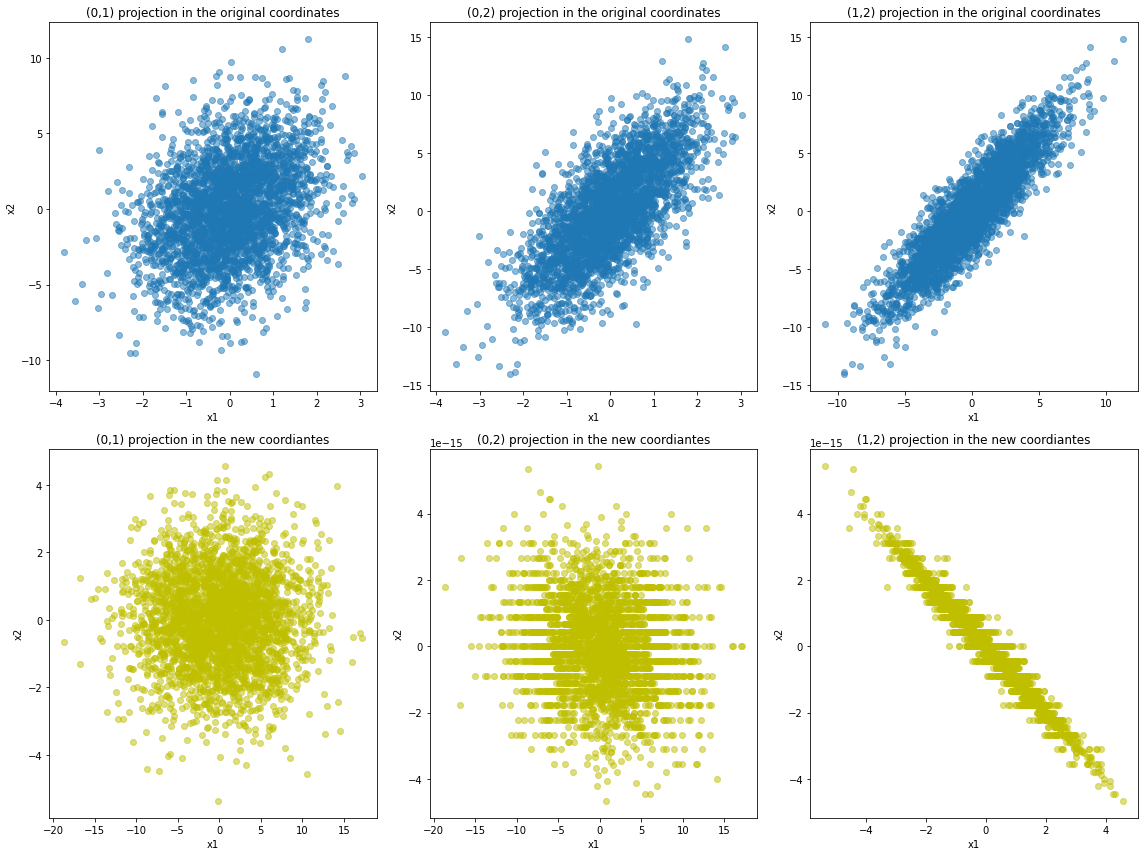

In [7]:
fig = plt.figure(figsize=(16, 12))

for i in range(len(dataset)):
    for j in range(i+1,len(dataset)):
        ax0=fig.add_subplot(2, 3, i+j)
        ax0.scatter(dataset[i,:], dataset[j,:],  alpha = 0.5)
        ax0.set_xlabel("x1")
        ax0.set_ylabel("x2")
        ax0.set_title("(" + str(i) + "," + str(j)+") projection in the original coordinates")
        ax1=fig.add_subplot(2, 3, i+j+3)
        ax1.scatter(rotdat[i,:],rotdat[j,:], alpha = 0.5, color = "y")
        ax1.set_xlabel("x1")
        ax1.set_ylabel("x2")
        ax1.set_title("(" + str(i) + "," + str(j)+") projection in the new coordiantes")

fig.tight_layout() #tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area.

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [8]:
#Add uncorrelated random noise:

numvar = 10
variable = np.random.normal(0,1/50,(numvar,N))
noise = np.concatenate(([x1],[x2],[x3],variable), axis =0)
    
#Repeat the PCA procedure

#covariance matrix of the dataset
cmn = np.cov(noise)
ln, Vn = la.eig(cmn) #l is the spectrum and V the normalized eigevectors
ln = np.real_if_close(ln) #If input is complex with all imaginary parts close to zero, return real parts. EigValue must be real

#sorting to than check that the two procedures yield to same result
idxn = np.argsort(-ln)
ln = ln[idxn]
Vn = Vn[:,idxn]

print("The covariance matrix of the dataset is:\n\n",cmn,'\n')

for i in range(len(noise)):
    print("Eigenvalue n. {}: ".format(i), ln[i], "\nEigenvector n. {}: ".format(i), Vn[:,i])

The covariance matrix of the dataset is:

 [[ 9.75930411e-01  1.01641334e+00  2.96827417e+00 -4.19723585e-05
   5.09289389e-05 -3.78526682e-04  8.51877843e-05  4.28402323e-04
   2.23957453e-04 -3.49927778e-04 -2.50003808e-04 -2.22404662e-04
  -2.10164256e-04]
 [ 1.01641334e+00  9.85561465e+00  1.18884413e+01 -1.54459738e-03
  -6.35360622e-04  8.98611085e-04 -2.05205228e-03  9.28042208e-04
  -8.88403773e-05  2.47945312e-04 -9.46484912e-04 -5.81728232e-04
  -5.33844869e-04]
 [ 2.96827417e+00  1.18884413e+01  1.78249897e+01 -1.62854210e-03
  -5.33502744e-04  1.41557720e-04 -1.88167671e-03  1.78484685e-03
   3.59074529e-04 -4.51910244e-04 -1.44649253e-03 -1.02653756e-03
  -9.54173380e-04]
 [-4.19723585e-05 -1.54459738e-03 -1.62854210e-03  3.90210691e-04
   7.08861409e-06  4.76027374e-06 -7.09969760e-06  2.71714477e-06
  -7.74466910e-06 -1.25744121e-05  6.13119799e-06  3.14949177e-06
  -7.77274124e-06]
 [ 5.09289389e-05 -6.35360622e-04 -5.33502744e-04  7.08861409e-06
   4.17082013e-04 -8.19

In [9]:
print("SVD method: ")
Un, spectrumn, Vtn = np.linalg.svd(cmn)
#U, spectrum, Vt = la.svd(cm)

for i in range(len(noise)):
    print("Eigenvalue n. {}: ".format(i), spectrumn[0], "\nEigenvector n. {}: ".format(i), Vtn[:,0])

SVD method: 
Eigenvalue n. 0:  26.72937534366357 
Eigenvector n. 0:  [-1.15966115e-01  5.65583797e-01 -2.41645908e-04  2.07003713e-04
 -1.19863943e-04  1.03090061e-04 -7.41417851e-05  3.75663724e-05
  7.85875215e-05 -5.50941690e-05 -1.32255904e-04 -4.19651366e-05
  8.16496581e-01]
Eigenvalue n. 1:  26.72937534366357 
Eigenvector n. 1:  [-1.15966115e-01  5.65583797e-01 -2.41645908e-04  2.07003713e-04
 -1.19863943e-04  1.03090061e-04 -7.41417851e-05  3.75663724e-05
  7.85875215e-05 -5.50941690e-05 -1.32255904e-04 -4.19651366e-05
  8.16496581e-01]
Eigenvalue n. 2:  26.72937534366357 
Eigenvector n. 2:  [-1.15966115e-01  5.65583797e-01 -2.41645908e-04  2.07003713e-04
 -1.19863943e-04  1.03090061e-04 -7.41417851e-05  3.75663724e-05
  7.85875215e-05 -5.50941690e-05 -1.32255904e-04 -4.19651366e-05
  8.16496581e-01]
Eigenvalue n. 3:  26.72937534366357 
Eigenvector n. 3:  [-1.15966115e-01  5.65583797e-01 -2.41645908e-04  2.07003713e-04
 -1.19863943e-04  1.03090061e-04 -7.41417851e-05  3.7566372

In [10]:
# Variability
Lambdan=np.diag(ln)

for i in range(len(ln)):
    vi = Lambdan[i,i]/Lambdan.trace()
    print("Eigenvalue n. {} percent of the variability : ".format(i), vi*100)

Eigenvalue n. 0 percent of the variability :  93.26190542844209
Eigenvalue n. 1 percent of the variability :  6.724090163220047
Eigenvalue n. 2 percent of the variability :  0.0015171706542621906
Eigenvalue n. 3 percent of the variability :  0.001496577270027084
Eigenvalue n. 4 percent of the variability :  0.001481298059156808
Eigenvalue n. 5 percent of the variability :  0.0014693658312113955
Eigenvalue n. 6 percent of the variability :  0.0014076304274754715
Eigenvalue n. 7 percent of the variability :  0.0013734879724500238
Eigenvalue n. 8 percent of the variability :  0.0013516107243284057
Eigenvalue n. 9 percent of the variability :  0.0013251410698080334
Eigenvalue n. 10 percent of the variability :  0.0013031064273093692
Eigenvalue n. 11 percent of the variability :  0.0012790199018278675
Eigenvalue n. 12 percent of the variability :  -3.726191081016013e-15


Text(0, 0.5, 'x2')

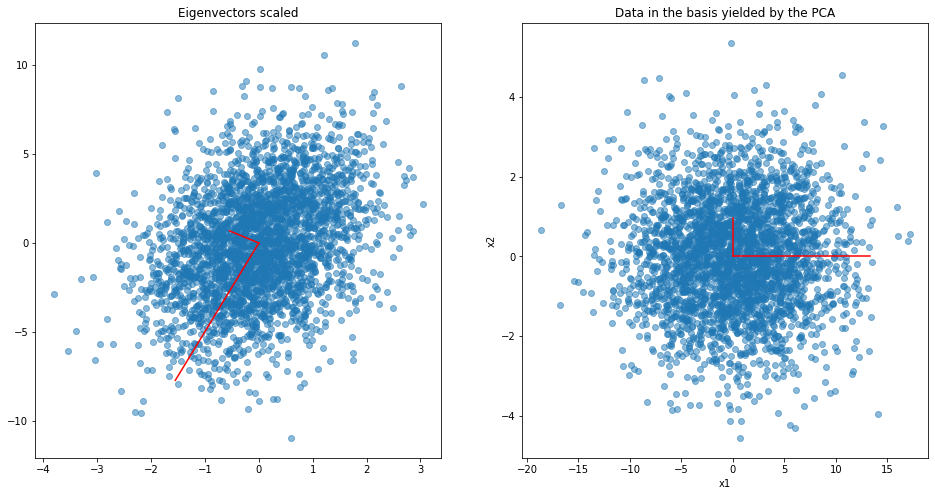

In [16]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax0.scatter(noise[0,:], noise[1,:],alpha = 0.5)
scale_factor=0.5

for li, vi in zip(ln, Vn.T): 
    ax0.plot([0, scale_factor*li*vi[0]], [0, scale_factor*li*vi[1]], color = "r")

ax0.set_title("Eigenvectors scaled")

# rotate all the data points accordingly to the new base

nrot = np.dot(Vn.T, noise)
ax1.scatter(nrot[0,:], nrot[1,:], alpha=0.5)

for li, vi in zip(ln, np.diag([1]*2)):
    plt.plot([0, scale_factor*li*vi[0]], [0, scale_factor*li*vi[1]], color = "r")

ax1.set_title("Data in the basis yielded by the PCA")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")

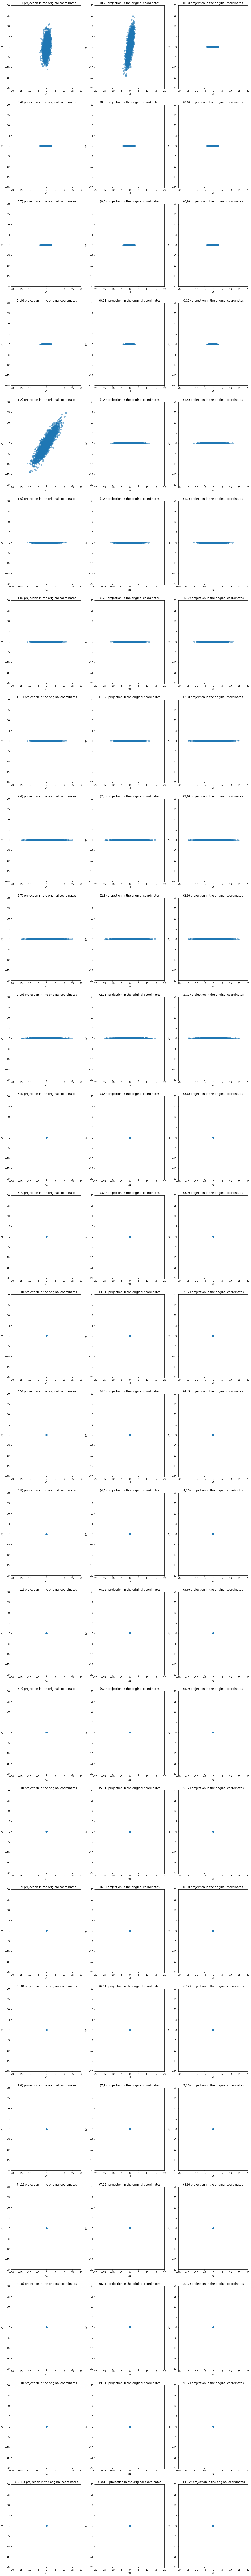

In [26]:
fig = plt.figure(figsize=(18, 200))

count = 1

for i in range(len(noise)):
    for j in range(i+1,len(noise)):
        ax0=fig.add_subplot(2*len(noise), 3, count)
        ax0.scatter(noise[i,:], noise[j,:],  alpha = 0.5)
        ax0.set_xlabel("x1")
        ax0.set_ylabel("x2")
        ax0.set_title("(" + str(i) + "," + str(j)+") projection in the original coordinates")
        plt.axis([-20,20,-20,20])
        count+=1

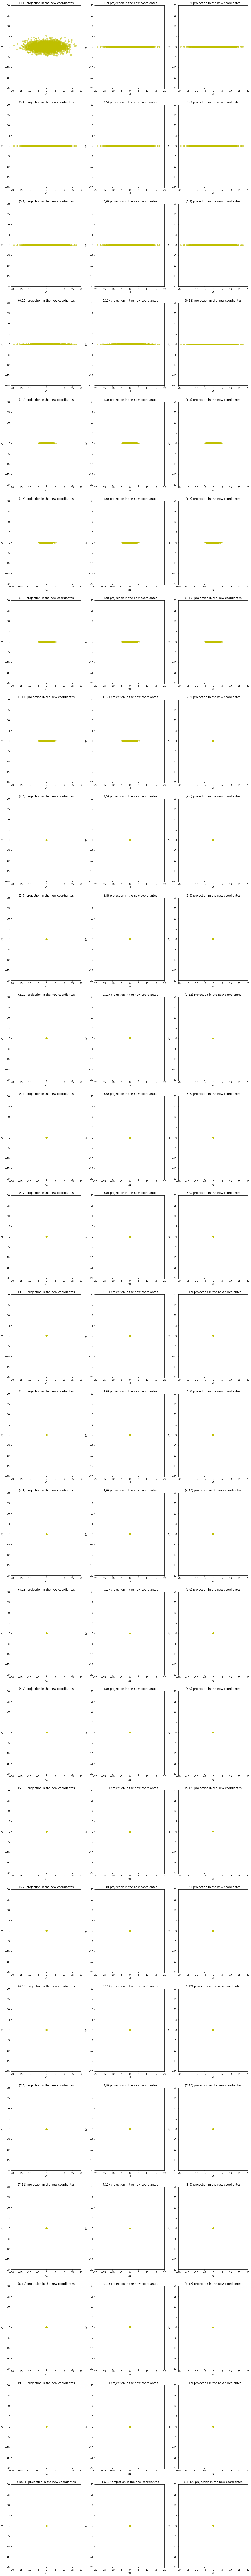

In [27]:
fig = plt.figure(figsize=(18, 200))

count = 1

for i in range(len(noise)):
    for j in range(i+1,len(noise)):
        ax1=fig.add_subplot(2*len(noise), 3, count)
    
        ax1.scatter(nrot[i,:],nrot[j,:], alpha = 0.5, color = "y")
        ax1.set_xlabel("x1")
        ax1.set_ylabel("x2")
        ax1.set_title("(" + str(i) + "," + str(j)+") projection in the new coordiantes")
        plt.axis([-20,20,-20,20])
        count+=1

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [ ]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 